In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx

import multiprocessing
from multiprocessing import Pool

import time
import ipdb
from IPython import display

%matplotlib inline

# Load data, Chicago road network
Source: [https://tzin.bgu.ac.il/~bargera/tntp/](https://tzin.bgu.ac.il/~bargera/tntp/)

In [2]:
nodes_org = pd.read_csv('./data/Chicago/node.csv')
nodes_org['x'] = (nodes_org['x'] - nodes_org['x'].min()) * 0.0003048
nodes_org['y'] = (nodes_org['y'] - nodes_org['y'].min()) * 0.0003048

edges_org = pd.read_csv('./data/Chicago/edge.csv')
    

## Zoom in the map

In [3]:
def filter_map(nodes, edges, x_min, x_max):
    y_min, y_max = x_min, x_max
    nodes = nodes.loc[(nodes['x']>x_min) & (nodes['x']<x_max)]
    nodes = nodes.loc[(nodes['y']>y_min) & (nodes['y']<y_max)]
    nodes.index = range(nodes.shape[0])
    
    new_edges = pd.DataFrame([], columns=edges.columns)
    node_list = list(nodes['NodeName'])
    for i in edges.index:
        if edges.loc[i, 'from'] in node_list and edges.loc[i, 'to'] in node_list:
            new_edges.loc[i] = edges.loc[i]
    new_edges.index = range(new_edges.shape[0])
    
    new_nodes = pd.DataFrame([], columns=nodes.columns)
    for i in nodes.index:
        if nodes.loc[i, 'NodeName'] in list(new_edges['from']) or nodes.loc[i, 'NodeName'] in list(new_edges['to']):
            new_nodes.loc[i] = nodes.loc[i]
    new_nodes.index = range(new_nodes.shape[0])
    new_nodes['NodeName'] = new_nodes['NodeName'].astype(int)
    
    return new_nodes, new_edges


In [4]:
nodes, edges = filter_map(nodes_org, edges_org, 97, 107)
nodes['x'] = nodes['x'] - nodes['x'].min()
nodes['y'] = nodes['y'] - nodes['y'].min()

In [5]:
edges['distance'] = ''
for i in edges.index:
    from_node = nodes.loc[nodes['NodeName']==edges.loc[i, 'from']]
    to_node = nodes.loc[nodes['NodeName']==edges.loc[i, 'to']]
    edges.loc[i, 'distance'] = np.linalg.norm(from_node[['x', 'y']].values.flatten() - to_node[['x', 'y']].values.flatten())

## Treat the map as a weighted graph
Distance is the link weight

In [6]:
G = nx.Graph()
G.add_nodes_from(nodes['NodeName'])
G.add_weighted_edges_from(edges.iloc[:, 1:].to_numpy())

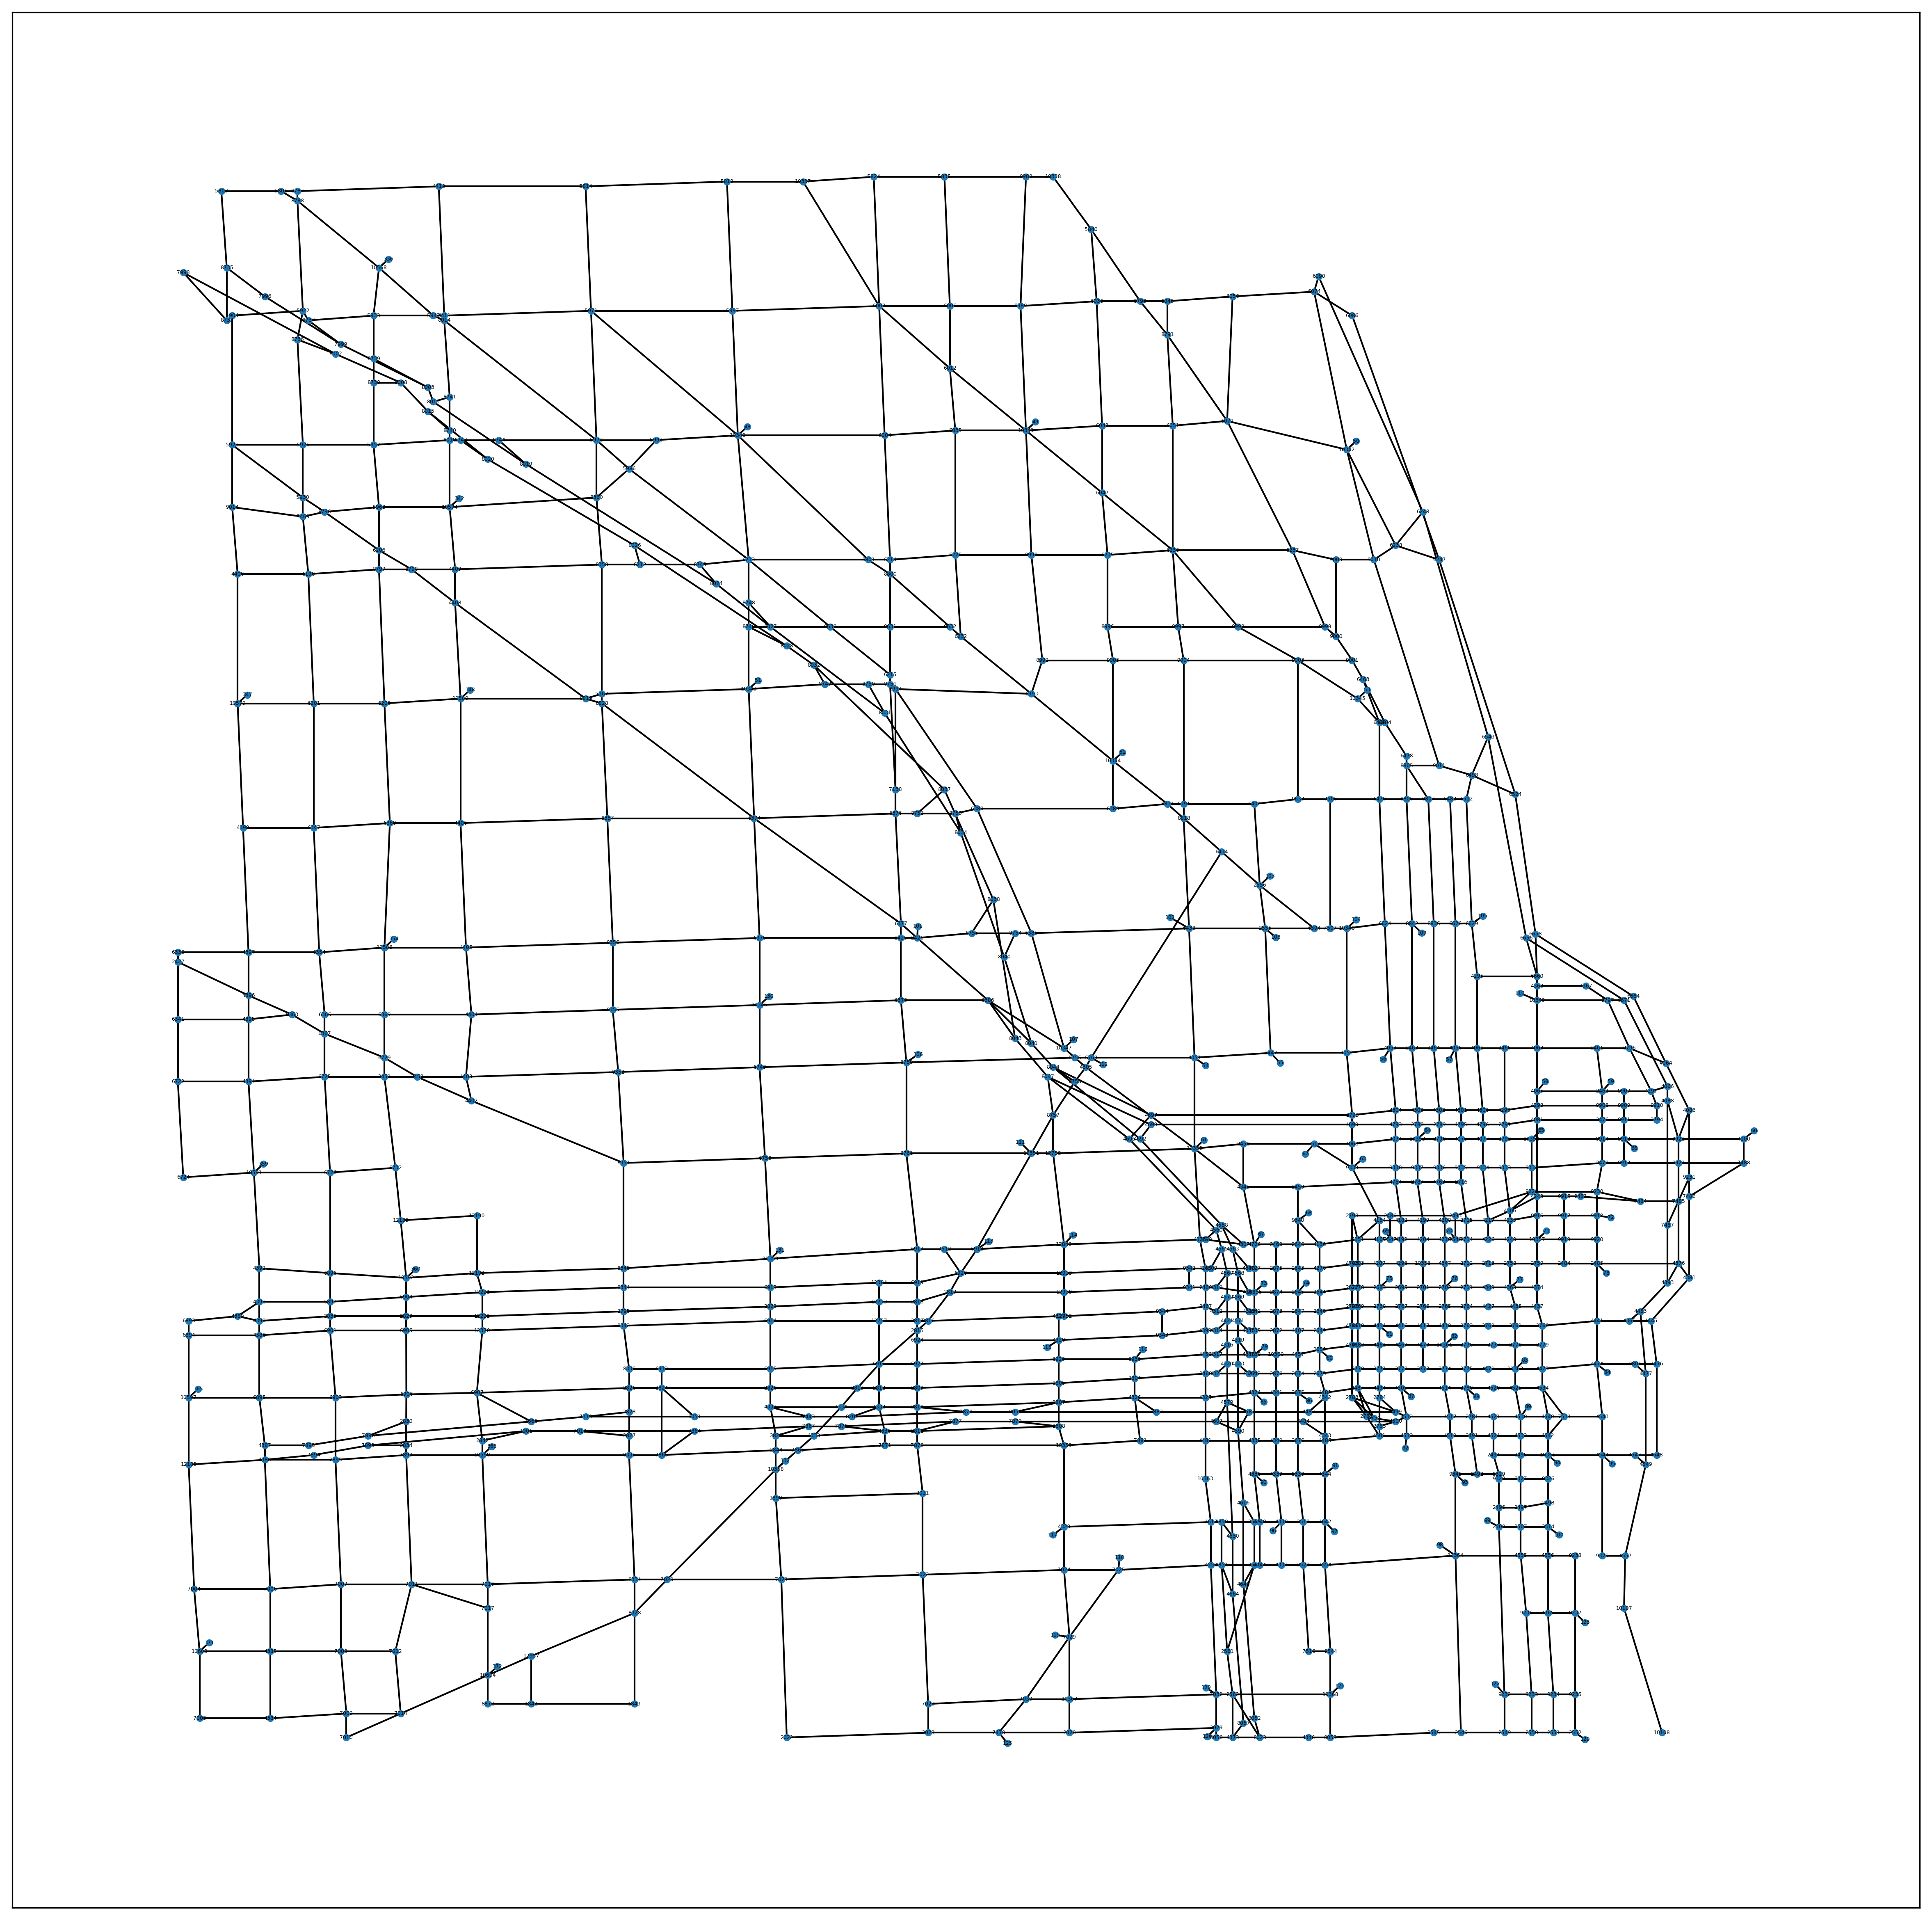

In [7]:
plt.figure(figsize=[20,20], dpi=300)
pos = dict(zip(nodes['NodeName'].to_numpy(), nodes[['x', 'y']].to_numpy()))
nx.draw_networkx(G, pos=pos, font_size=3, node_size=10)

Try Dijkstra method

In [8]:
nx.dijkstra_path(G, 5933, 2766)

[5933,
 8739,
 8003,
 8011,
 8019,
 8024,
 8027,
 8031,
 8034,
 8040,
 8041,
 8044,
 4692,
 4558,
 4563,
 4568,
 4311,
 10355,
 2641,
 2873,
 2647,
 2648,
 2769,
 2768,
 2767,
 2766]

# Define rider

In [9]:
from rider import *

# Define platform


In [10]:
class platform:
    def __init__(self, r, cR, k, t):
        # state can be "waiting", "matched"
        self.customer_df = pd.DataFrame(
            [],
            columns=[
                'node_ID',
                'merchant_node',
                'state',
                'waiting_time',
                'position_x',
                'position_y'
            ]
        )

        self.matched_customer_df = pd.DataFrame(
            [],
            columns=[
                'node_ID',
                'merchant_node',
                'state',
                'waiting_time',
                'position_x',
                'position_y'
            ]
        )
        
        self.num_accumulated_order = 0
        self.r = r
        self.cR = cR
        self.k = k
        self.t = t
    
    def update_cust_df_with_new_cust(self, n=1):
        c = 0
        while True and n > 0:
            ind = self.customer_df.shape[0]
            node_ID = np.random.choice(list(nodes['NodeName']))
            node_position = get_node_xy(node_ID)
            merchant_node = np.random.choice(merchant_node_set)
            
            if np.linalg.norm(node_position - get_node_xy(merchant_node)) < cR:
                new_customer = pd.DataFrame(
                    [[node_ID, merchant_node, 'waiting', 0, node_position[0], node_position[1]]],
                    index=[ind],
                    columns=['node_ID', 'merchant_node', 'state', 'waiting_time', 'position_x', 'position_y']
                )
                self.customer_df = pd.concat([self.customer_df, new_customer], axis=0)
                c = c + 1
                
            if c == n:
                break
    
    def acquire_order(self, q):
        # num_generated_order_c is continuous ('_c'), not discrete
        num_generated_order_c = np.random.rand() * q * t_resolution * 2
        self.num_accumulated_order += num_generated_order_c
        num_generated_order = int(self.num_accumulated_order - self.customer_df.shape[0])
        
        self.update_cust_df_with_new_cust(num_generated_order)
        
        self.customer_df.loc[self.customer_df['state']!='delivered', 'waiting_time'] = \
                self.customer_df.loc[self.customer_df['state']!='delivered', 'waiting_time'] + t_resolution
    
    def update_matched_order(self, matched_batches):
        self.customer_df.loc[self.customer_df['node_ID'].isin(matched_batches.flatten()), 'state'] = 'matched'
        self.matched_customer_df = pd.concat(
            [self.matched_customer_df, self.customer_df.loc[self.customer_df['state']=='matched']]
        )
        self.customer_df = self.customer_df.drop(
            index=self.customer_df.loc[self.customer_df['state']=='matched'].index
        )
        
        self.matched_customer_df.index = range(self.matched_customer_df.shape[0])
        self.customer_df.index = range(self.customer_df.shape[0])
        
        self.num_accumulated_order -= matched_batches.size
    
    def match(self, idle_rider_IDs, rider_set):
        # when multiprocessing, the rider ID and index of each rider
        # in the rider_set list are not necessarily the same
        rider_ID_set = [i.ID for i in rider_set]
        rider_index_df = pd.DataFrame(range(len(rider_ID_set)), index=rider_ID_set, columns=['ind'])
        
        matched_batches = []
        matched_rider_IDs = []
        matched_merchants = []
        
        for i in range(len(merchant_node_set)):
            # first find corresponding idle rider IDs
            merchant_node = merchant_node_set[i]
            idle_rider_IDs_this_merchant = []
            for idle_rider_ID in idle_rider_IDs:
                idle_rider = rider_set[rider_index_df.loc[idle_rider_ID, 'ind']]
                if idle_rider.closest_merchant_node==merchant_node:
                    idle_rider_IDs_this_merchant.append(idle_rider_ID)
            n_idle_riders_this_merchant = len(idle_rider_IDs_this_merchant)
            
            # accumulatd orders for this merchant
            acc_ord_this_mer_df = self.customer_df.loc[self.customer_df['merchant_node']==merchant_node]
            acc_ord_this_mer = acc_ord_this_mer_df['node_ID'].astype(int).values
            
            num_required_riders_this_merchant = min(
                n_idle_riders_this_merchant,
                # number of accumulated orders for this merchant // k
                len(acc_ord_this_mer) // self.k
            )
            
            matched_rider_IDs_this_merchant = list(np.random.choice(
                idle_rider_IDs_this_merchant,
                num_required_riders_this_merchant,
                replace=False
            ))
            
            matched_batches_this_merchant = []
            for j in range(len(matched_rider_IDs_this_merchant)):
                matched_batches_this_merchant.append(acc_ord_this_mer[self.k*j:self.k*(j+1)])
                matched_merchants.append(merchant_node)
            matched_batches_this_merchant = np.array(matched_batches_this_merchant)
            
            matched_batches.extend(matched_batches_this_merchant)
            matched_rider_IDs.extend(matched_rider_IDs_this_merchant)
        
        matched_batches = np.array(matched_batches)
        # remove the matched orders
        self.update_matched_order(matched_batches)
        W_cq_4_matched_customers = []
        for i in np.array(matched_batches).flatten():
            W_cq_4_matched_customers.append(self.customer_df['waiting_time'])
        avg_W_cq = np.mean(W_cq_4_matched_customers) if len(W_cq_4_matched_customers)>0 else np.nan
        
        # their indexes are mutually matched
        return matched_batches, matched_rider_IDs, matched_merchants, avg_W_cq  
        

In [11]:
# Multi processing, but it is slower if only step one pace forward
def move_all_riders():
    # number of riders at each process
    N_each_process = N // (n_cpu - 1) if N%n_cpu != 0 else N // n_cpu
    n_process = N//N_each_process+1 if N%N_each_process != 0 else N//N_each_process

    params = []
    for i in range(n_process):
        params.append(
            [
                rider_set[i*N_each_process:(i+1)*N_each_process],
                t_resolution,
                matched_rider_IDs,
                matched_batches,
                matched_merchants,
                dec_var
            ]
        )
    
    moved_rider_set = pool.starmap(func=move_rider, iterable=params )
    return moved_rider_set


In [12]:
config_set = []
rider_set = []
N = 350
q_bar = 500
r = 2
cR = 5
k = 3
t = 0.005

Delta = cR
t_resolution = 0.001
match_period = t//t_resolution if t%t_resolution==0 else t//t_resolution+1

dec_var = {
    'r': r,
    'cR': cR,
    'k': k,
    't': t,
    'N': N,
    'q_bar': q_bar
}

merchant_node_set = [10343, 2766, 6907, 6237]

In [13]:
num_new_riders = N


num_exist_riders = len(rider_set)
new_rider_count = 0
while new_rider_count < num_new_riders:
    config_i = {
        'ID': num_exist_riders + new_rider_count,
        'initial_position': np.array([np.random.rand()*nodes['x'].max(), np.random.rand()*nodes['y'].max()]),
        'maxspeed': np.random.randint(10, 20)
    }
    rider_i = rider(config_i, dec_var, merchant_node_set)
    
    config_set.append(config_i)
    rider_set.append(rider_i)
    
    new_rider_count += 1

In [14]:
virtual_plat = platform(r, cR, k, t)

In [15]:
c = 0
x_axis = []
num_idle_rider_IDs_set = []
num_accumulated_batch_set = []
p_set = []
pp_set = []
avg_W_cq_set = []

In [16]:
n_cpu = multiprocessing.cpu_count()
pool = Pool(processes=n_cpu)

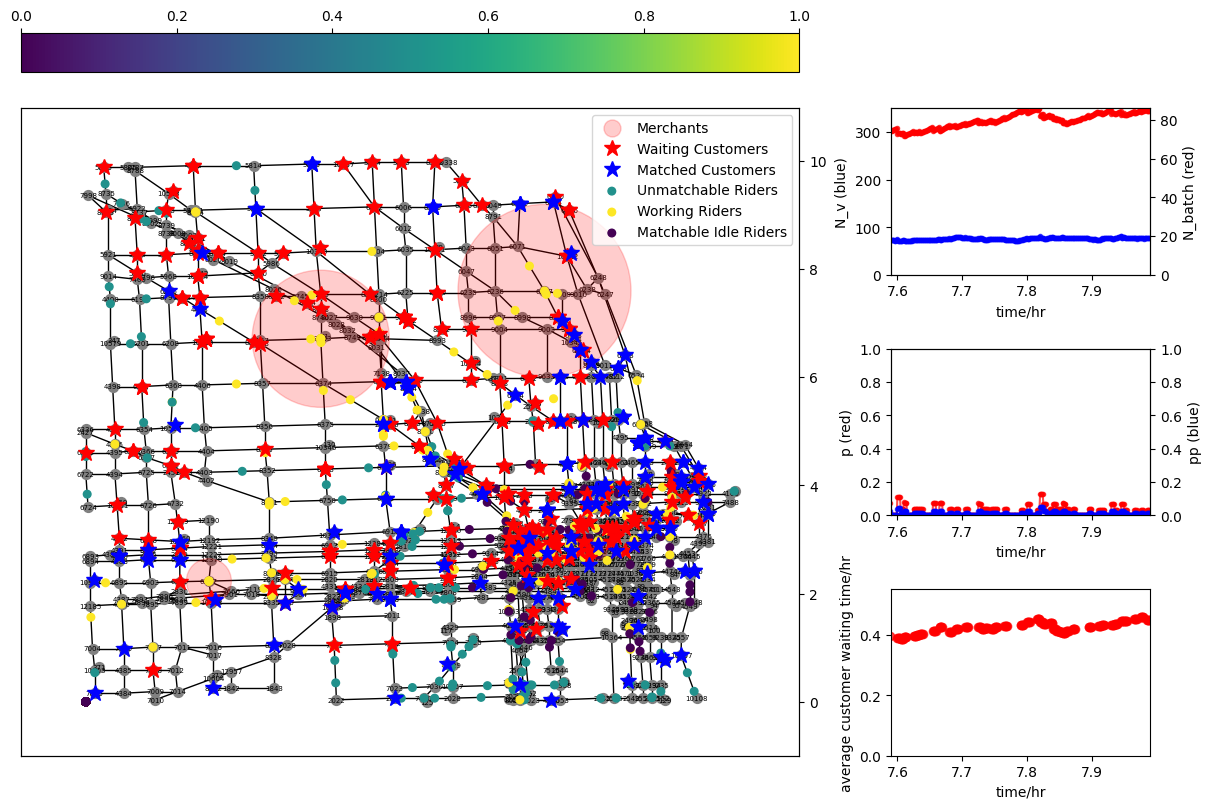

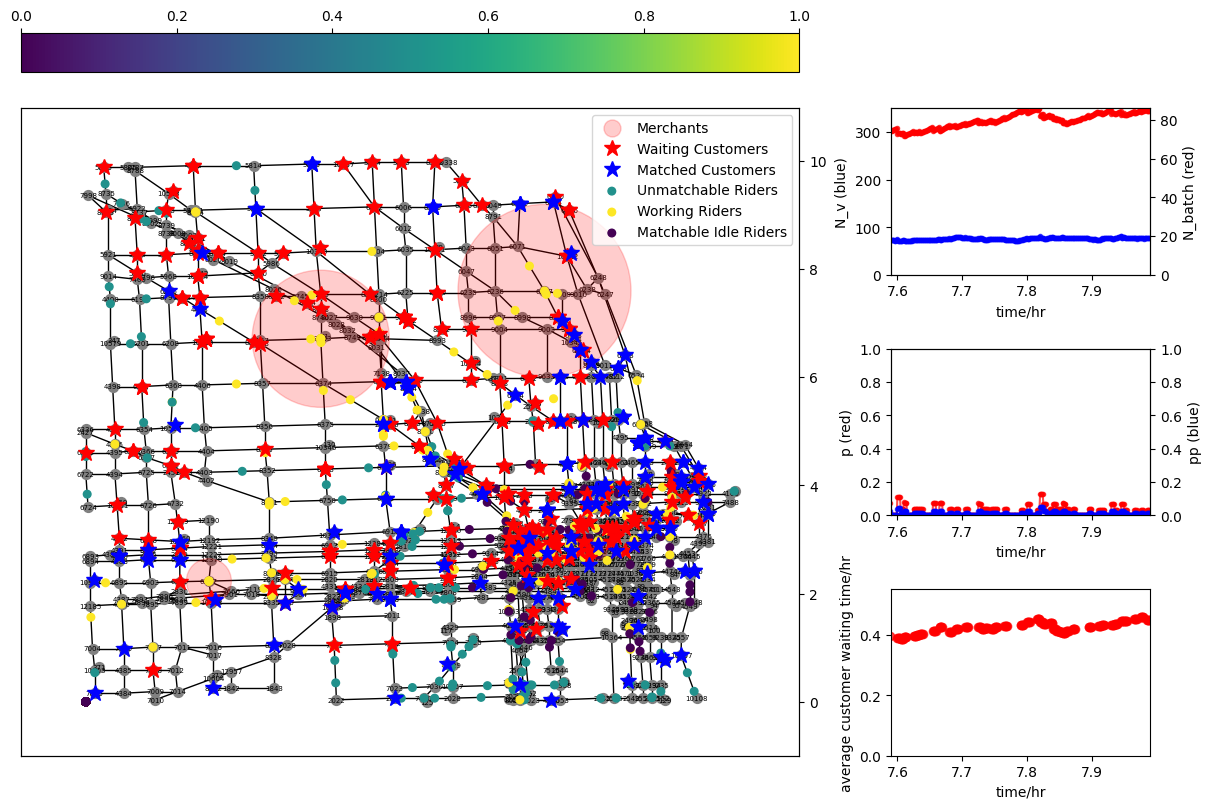

In [20]:
# marking the x-axis and y-axis
fig = plt.figure(constrained_layout=True, figsize=[12, 8])
gs = fig.add_gridspec(3, 4)
ax0 = fig.add_subplot(gs[:3, :3])
ax0.set_xlim(-nodes['x'].max()*0.1, nodes['x'].max()*1.1)
ax0.set_ylim(-nodes['y'].max()*0.1, nodes['y'].max()*1.1)
ax = ax0.twinx()
ax.set_xlim(-nodes['x'].max()*0.1, nodes['x'].max()*1.1)
ax.set_ylim(-nodes['y'].max()*0.1, nodes['y'].max()*1.1)

ax2 = fig.add_subplot(gs[0, 3])
ax2.set_ylabel('N_v (blue)')
ax2.set_xlabel('time/hr')
ax3 = ax2.twinx()
ax3.set_ylabel('N_batch (red)')
ax3.set_xlabel('time/hr')
ax4 = fig.add_subplot(gs[1, 3])
ax4.set_ylabel('p (red)')
ax4.set_xlabel('time/hr')
ax4.set_ylim([0, 1])
ax5 = ax4.twinx()
ax5.set_ylabel('pp (blue)')
ax5.set_xlabel('time/hr')
ax5.set_ylim([0, 1])
ax6 = fig.add_subplot(gs[2, 3])
ax6.set_ylabel('average customer waiting time/hr')
ax6.set_xlabel('time/hr')

# plt.tight_layout()

nx.draw_networkx(G, pos=pos, ax=ax0, node_size=50, font_size=5, node_color='gray')

scat4 = ax.scatter([], [], color='red', alpha=0.2, label='Merchants', s=150)  # for merchants
scat2, = ax.plot([], [], 'r*', markersize=12, label='Waiting Customers')  # for waiting customers
scat3, = ax.plot([], [], 'b*', markersize=12, label='Matched Customers')  # for matched customers
# riders
color = np.ones(N) * 0.5
scat = ax.scatter(np.zeros(len(rider_set)), np.zeros(len(rider_set)), s=30, c=np.ones(N) * 0.5, vmin=0, vmax=1, label='Unmatchable Riders')
ax.scatter(np.zeros(len(rider_set)), np.zeros(len(rider_set)), s=30, c=np.ones(N), vmin=0, vmax=1, label='Working Riders')
ax.scatter(np.zeros(len(rider_set)), np.zeros(len(rider_set)), s=30, c=np.zeros(N), vmin=0, vmax=1, label='Matchable Idle Riders')
fig.colorbar(scat, ax=ax, location='top')
ax.legend(loc='upper right')

line2, = ax2.plot([], [], 'b.-', alpha=0.7)
line3, = ax3.plot([], [], 'r.-', alpha=0.7)
line4, = ax4.plot([], [], 'r.-', alpha=0.7)
line5, = ax5.plot([], [], 'b.-', alpha=0.7)
line6, = ax6.plot([], [], 'ro-', alpha=0.7)

while c < 8000:
    idle_rider_IDs = []
    for i in range(N):
        if rider_set[i].state=='idle' and rider_set[i].if_matchable:
            idle_rider_IDs.append(rider_set[i].ID)
    
    q = q_bar * cR**2 / Delta**2
    virtual_plat.acquire_order(q)
    
    if c%match_period==0:
        matched_batches, matched_rider_IDs, matched_merchants, avg_W_cq = virtual_plat.match(
            idle_rider_IDs, rider_set
        )
    
    num_matched_cust = matched_batches.size
    try:
        p = num_matched_cust / (num_matched_cust + virtual_plat.num_accumulated_order/k)
    except:
        # when there is no order
        p = 1
    try:
        pp = len(matched_rider_IDs) / len(idle_rider_IDs)
    except:
        pp = 1

    # move
#     rider_set = move_rider(
#         rider_set, t_resolution, matched_rider_IDs, matched_batches, matched_merchants, dec_var
#     )
    # for multiprocessing, uncomment the following lines
    moved_rider_set = move_all_riders()
    moved_rider_set = [item for sublist in moved_rider_set for item in sublist]
    rider_set = moved_rider_set
    
    # update delivered customers
    delivered_customers_set = []
    for each_rider in rider_set:
        delivered_customers_set.extend(each_rider.finished_destination)
    virtual_plat.matched_customer_df = virtual_plat.matched_customer_df.drop(
        virtual_plat.matched_customer_df.loc[
            virtual_plat.matched_customer_df['node_ID'].isin(delivered_customers_set)
        ].index
    )
    
    time = c*t_resolution
    x_axis.append(time)
    num_idle_rider_IDs_set.append(len(idle_rider_IDs))
    num_accumulated_batch_set.append(virtual_plat.num_accumulated_order/k)  # continuous
    p_set.append(p)
    pp_set.append(pp)
    avg_W_cq_set.append(avg_W_cq)
    
    if c%10==0:
        # plot merchants
        merchant_pos = [[get_node_xy(i)[0], get_node_xy(i)[1]] for i in merchant_node_set]
        scat4.set_offsets(np.array(merchant_pos))
        acc_orders_by_merchant = []
        for i in merchant_node_set:
            acc_orders_by_merchant.append(virtual_plat.customer_df.loc[virtual_plat.customer_df['merchant_node']==i].shape[0])
        scat4.set_sizes(150 + np.array(acc_orders_by_merchant)**2)
        
        # plot customers
        if virtual_plat.customer_df.shape[0]>0:
            cust_pos = np.array(virtual_plat.customer_df[['position_x', 'position_y']].to_numpy())
            scat2.set_data(cust_pos.T)
        if virtual_plat.matched_customer_df.shape[0] > 0:
            cust_pos_m = np.array(virtual_plat.matched_customer_df[['position_x', 'position_y']].to_numpy())
            scat3.set_data(cust_pos_m.T)
        
        # plot riders
        for i in range(N):
            if rider_set[i].state == 'idle' and rider_set[i].if_matchable:
                color[i] = 0
            elif rider_set[i].state == 'working' or rider_set[i].state == 'stop':
                color[i] = 1
            elif rider_set[i].state == 'idle' and rider_set[i].if_matchable==False:
                color[i] = 0.5
        scat.set_array(color)
        scat.set_offsets(
            np.array( [ [rider_set[i].position[0], rider_set[i].position[1]] for i in range(N)] )
        )
        
        line2.set_data(x_axis, num_idle_rider_IDs_set)
        ax2.set_ylim([min(num_idle_rider_IDs_set), N])
        line3.set_data(x_axis, num_accumulated_batch_set)
        ax3.set_ylim([0, max(num_accumulated_batch_set)])
        line4.set_data(x_axis, p_set)
        line5.set_data(x_axis, pp_set)
        line6.set_data(x_axis, avg_W_cq_set)

        ax2.set_xlim([max(0, time - 0.4), time])
        ax3.set_xlim([max(0, time - 0.4), time])
        ax4.set_xlim([max(0, time - 0.4), time])
        ax5.set_xlim([max(0, time - 0.4), time])
        ax6.set_xlim([max(0, time - 0.4), time])
        if np.isnan(np.nanmax(avg_W_cq_set))==False:
            ax6.set_ylim([0, 1.2 * np.nanmax(avg_W_cq_set)])

        display.clear_output(wait=True)
        display.display(plt.gcf())
    
        fig.savefig('./res_img/%.4f.png'%time, dpi=75)
    c += 1
    

In [21]:
# make gif
import glob
from PIL import Image
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save('./res_img/demo.gif', format="GIF", append_images=frames,
               save_all=True, duration=35, loop=0)
    

make_gif("./res_img/")